In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import igraph as ig
import os
import yaml
from os.path import join
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from scipy.stats import entropy
from scipy import stats
from functools import reduce
import sys
sys.path.insert(1, '..')
from utils import *
from collections import Counter
import geopandas as gpd
import matplotlib.ticker as ticker
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
FIG_SAVE_DIR = join('..', '..', 'figures')
RESULT_SAVE_DIR = join('..', '..', 'results')

In [12]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
AREA_NAME = 'NYC'

PATTERN_DIR = join(pwd, dpath, 'filtered-patterns', f'{AREA_NAME}-patterns-v2')
dfiles = sorted([(join(PATTERN_DIR, f), datetime.strptime(f.split('.')[0], '%Y-%m-%d')) for f in os.listdir(PATTERN_DIR)], key=lambda x: x[1])

In [24]:
def get_none_home_cbgs(row):
    home_cbg = str(row['poi_cbg'])
    visitors = json.loads(row['visitor_home_cbgs'])
    s = 0
    for v in visitors:
        if v != home_cbg:
            s += visitors[v]
    return s

In [60]:
r = {
    'Raw Visit Counts': [],
    'Median Dwell Time (in Minutes)': [],
    'Distance From Home CBG (in Meters)': [],
    '# of Visitors From Other CBGs': [],
    'date': []
}

for dfile in tqdm(dfiles):
    r['date'].append(dfile[1])
    df = pd.read_csv(dfile[0])
    
    r['Raw Visit Counts'].append(df['raw_visit_counts'].mean())
    r['Distance From Home CBG (in Meters)'].append(df['distance_from_home'].mean())
    r['Median Dwell Time (in Minutes)'].append(df['median_dwell'].mean())
    r['# of Visitors From Other CBGs'].append(np.mean(df.apply(get_none_home_cbgs, axis=1)))

results = pd.DataFrame(r)

100%|████████████████████████████████████████████████████████████████████████████████| 107/107 [02:29<00:00,  1.40s/it]


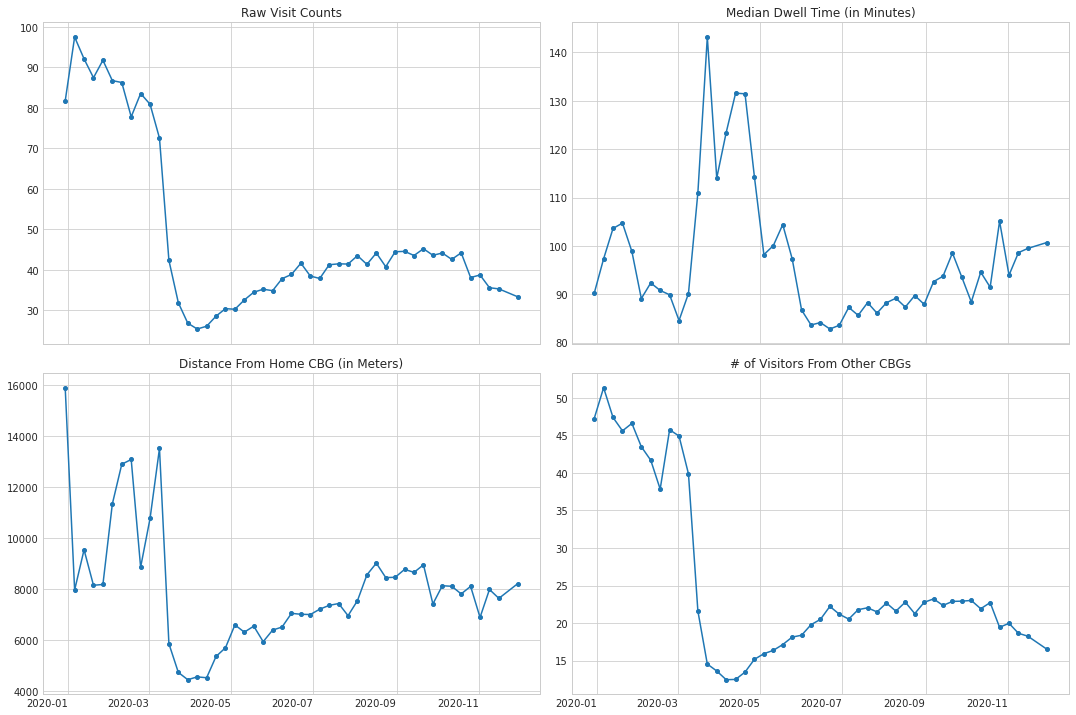

In [62]:
with plt.style.context('seaborn-whitegrid'):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)

    dr = results.set_index('date')
    tdate = datetime(2019, 12, 24)
    fdate = datetime(2020, 12, 1)
    dr = dr.loc[(dr.index > tdate) & (dr.index < fdate)]

    for ax, col in zip(axes.flatten(), dr.columns):
        dr[col].plot(ax=ax, title=col, marker='o', markersize=4, rot=0)
        ax.set_xlabel('')
        #ax.grid()

    fig.tight_layout()
    fig.savefig('nyc-mob-attr-change.png', bbox_inches='tight')